In [1]:

import sys
sys.path.append("./modules")


In [2]:
# Import general modules
from nansat import Nansat, Domain, NSR
import os 

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import SAR forecasting modules
import config
import s1_preparation
import domains_preparation
import SAR1_SAR2_drift_retrivial
import warping_with_domain

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs

In [3]:
# 1. Prepare SAR pairs

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE 
timestamp: 2023-02-12 08:01:51
SAR2: S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014.SAFE 
timestamp: 2023-02-14 07:45:31


In [4]:
# 2.1. Prepare nansat objects and domains (for each sar pair)

#Prepare nansat objects for HV polarisation
n1_hv, n2_hv, output_dir_name, plots_dir_hv =  domains_preparation.prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HV')

#Prepare nansat objects for HH polarisation
n1_hh, n2_hh, output_dir_name, plots_dir_hh =  domains_preparation.prepare_nansat_objects(sar_pairs[1][0], sar_pairs[1][1], output_folder, polarisation='HH')




VMIN:  -3.9498636960983275
VMAX:  5.663959283828735
VMIN:  -3.5571017265319824
VMAX:  5.484246134757996
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/HV_plots
VMIN:  -3.774366235733032
VMAX:  5.102492332458496
VMIN:  -3.0308663845062256
VMAX:  4.180728316307068
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/HH_plots


In [5]:
# 2.2  Define model domain (mod_dom) for comparing drift and comparison (dst_dom) domain to compare SAR images (real and forecasted)

# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, lon_subset, lat_subset = domains_preparation.prepare_grid(n1_hv, n2_hv, srs, X, Y, lon, lat, buffer=0)

# Set a model domain
mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - mod_res * 2} {max(X_subset.data) + mod_res} {max(Y_subset.data)} -tr {mod_res} {mod_res}')


lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)

# Set a comparison domain 
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data) - dst_res * 2} {max(X_subset.data) + dst_res} {max(Y_subset.data)} -tr {dst_res} {dst_res}')

domains_preparation.plot_borders(mod_dom, n1_hv, n2_hv, output_dir_name) # borders for hh and hv are the same

'/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20230212T080151_20230214T074531/General_plots/images_vs_domain_borders.png'

In [17]:
rows1, cols1 = dst_dom.shape()
dst_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs)
#, mod_dom

(array([278603.1875, 823603.1875, 278603.1875, 823603.1875]),
 array([774568.375, 774568.375,  69568.375,  69568.375]))

In [18]:
rows1, cols1 = mod_dom.shape()
mod_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs)

(array([278603.1875, 823603.1875, 278603.1875, 823603.1875]),
 array([774568.375, 774568.375,  69568.375,  69568.375]))

In [10]:
# 3.   Retrieve reference drift
# 3.1. Run feature tracking and pattern matching for HV

# Run feature tracking and plot results 
c1_hv, r1_hv, c2_hv, r2_hv = SAR1_SAR2_drift_retrivial.run_feature_tracking(n1_hv, n2_hv, plots_dir_hv)

#Run pattern matching and plot results
upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv = SAR1_SAR2_drift_retrivial.run_pattern_matching(plots_dir_hv, x, y, 
                                                           lon1pm, lat1pm, n1_hv, c1_hv, r1_hv, n2_hv, c2_hv, r2_hv, srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[-9,-6, -3, 0, 3, 6, 9]) #test
                                                           angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 37701
Domain filter: 50000 -> 48850
Keypoints matched 3.988931179046631
Ratio test 0.600000 found 1552 keypoints
MaxDrift filter: 1552 -> 1552
LSTSQ filter: 1552 -> 1523
100% 03208.0 05242.4 04096.0 05306.0 -35.0 0.35 3.63 0.12
 Pattern matching - OK! (472 sec)


In [11]:
# 3.2. Run feature tracking and pattern matching for HH

# HH Processing
# Run feature tracking and plot results 
c1_hh, r1_hh, c2_hh, r2_hh = SAR1_SAR2_drift_retrivial.run_feature_tracking(n1_hh, n2_hh, plots_dir_hh)

#Run pattern matching and plot results
upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh = SAR1_SAR2_drift_retrivial.run_pattern_matching(plots_dir_hh, x, y, 
                                                           lon1pm, lat1pm, n1_hh, c1_hh, r1_hh, n2_hh, c2_hh, r2_hh,srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[-9,-6, -3, 0, 3, 6, 9]) #test
                                                           angles=[-50, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 50 ])

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 43258
Domain filter: 50000 -> 48486
Keypoints matched 4.317245721817017
Ratio test 0.600000 found 489 keypoints
MaxDrift filter: 489 -> 489
LSTSQ filter: 489 -> 481


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


85% 02551.3 04250.4 03534.0 04466.0 +09.0 0.53 15.77 0.4398% 01837.9 04844.5 02841.0 05223.0 +12.0 0.34 7.49 0.1789% 02838.1 04475.1 03929.0 04638.0 +30.0 0.27 4.60 0.17
 Pattern matching - OK! (413 sec)


In [19]:
# 3.3 Get combined drift and all textural parameters

# Combining hh and hv results based on hessian threshold
upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm = SAR1_SAR2_drift_retrivial.combine_hh_hv(output_dir_name, x, y, upm_hh, vpm_hh, apm_hh, rpm_hh, hpm_hh, ssim_hh, lon2pm_hh, lat2pm_hh,
                              upm_hv, vpm_hv, apm_hv, rpm_hv, hpm_hv, ssim_hv, lon2pm_hv, lat2pm_hv)

In [24]:
from SAR1_SAR2_drift_retrivial import save_sar_drift_results

In [32]:
# 3.4  Get good pixel indices based on hessian and neighbor thresholds.

#Returns:
#    - gpi1: Good pixel index based on hessian value
#    - gpi2: Good pixel index combining hessian and neighbors count 

hessian=8
neighbors=3

gpi1, gpi2 = SAR1_SAR2_drift_retrivial.get_good_pixel_indices(hpm, h_threshold=hessian, neighbors_threshold=neighbors)

    
# Plot the filtering results
SAR1_SAR2_drift_retrivial.plot_filter_results(output_dir_name, x, y, hpm, upm, vpm, gpi1, gpi2, hessian, neighbors)


# Save final drift, its parameters and filtering arrays to npy files
save_name = 'sar_ref_drift_output'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name, upm, vpm, apm, rpm, hpm, ssim, lon2pm, lat2pm, gpi1, gpi2)

TypeError: plot_filter_results() takes 9 positional arguments but 10 were given

1. done. Add function plotting drift field before and after filtering to SAR1_SAR2_drift_retrivial module
2. done. Safe all variables as npy files together with arrays for both gpi
3. done. (left the same, added hh and hv) Come up with good variables names for forecasted hh and hv images using reference data
4. done. (removed SAR1) Add plotting of SAR1, SAR1_forecasted, SAR2 images for output
5. Get Cor, Hes, and SSMI for SAR1_forecasted, SAR2 images for output
6. If I want save output arrays what extra information I need to keep to be able to plot them? or just domain and then shall I keep domains teh same for all runs?
7. I can create after a notebook where I open images and research them in more details
8. Get model data automatically (I hope so much it won't take too much time)
9. Warp with model data
10. Get Cor, Hes, and SSMI for SAR1_forecasted, SAR2 images for output
11. Find teh difference between Cor, Hes, and SSMI for ref and mod drift
12. Add deformation calcualtion for both ref and mod drift and compare with SSMI !!!!(ask tomorrow Anton to help with this code)

In [6]:
# Load parameter without running again ft and  pm  if kernel died
save_name = 'sar_ref_drift_output'
                                     
sar_drift_output_path = os.path.join(output_dir_name, f"{save_name}")
sar_drift_output_path = os.path.join(sar_drift_output_path, f"{save_name}.npz")
                                     
                                     
loaded_arrays = np.load(sar_drift_output_path)

# Extract individual arrays
upm = loaded_arrays['upm']
vpm = loaded_arrays['vpm']
apm = loaded_arrays['apm']
rpm = loaded_arrays['rpm']
hpm = loaded_arrays['hpm']
ssim = loaded_arrays['ssim']
lon2pm = loaded_arrays['lon2pm']
lat2pm = loaded_arrays['lat2pm']
gpi1 = loaded_arrays['gpi1']
gpi2 = loaded_arrays['gpi2']

# Close the .npz file after extraction
loaded_arrays.close()

In [ ]:
# 4. Warping SAR1 image with the reference sar drift and compare all arrays in the comparison distination domain

# Warp SAR1 with SAR-drift compenstaion/displacement
good_pixels = gpi2
mask_pm = ~good_pixels # mask out low quality or NaN
s1_dst_dom_S_hv = warping_with_domain.warp_with_uv(n1_hv, n1_hv[1], mod_dom, upm, vpm, mask_pm, dst_dom)
s1_dst_dom_S_hh = warping_with_domain.warp_with_uv(n1_hh, n1_hh[1], mod_dom, upm, vpm, mask_pm, dst_dom)

# Warp SAR2 to the comparison domain
s2_dst_dom_hv = warping_with_domain.warp(n2_hv, n2_hv[1], dst_dom)
s2_dst_dom_hh = warping_with_domain.warp(n2_hh, n2_hh[1], dst_dom)

# Warp SAR1 to the comparison domain for visualisation
s1_dst_dom_hv = warping_with_domain.warp(n1_hv, n1_hv[1], dst_dom)
s1_dst_dom_hh = warping_with_domain.warp(n1_hh, n1_hh[1], dst_dom)

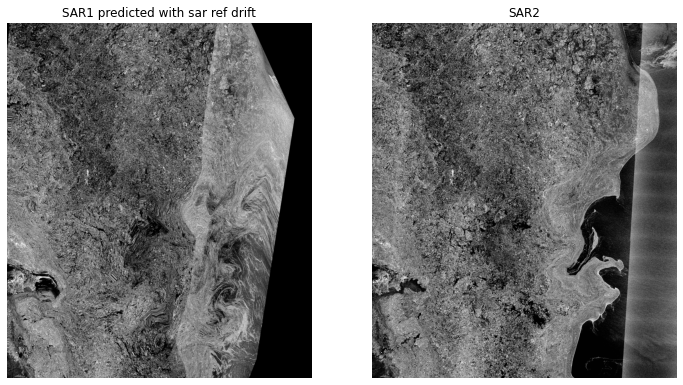

In [11]:
fig, axs = plt.subplots(1,2, figsize=(12,9))

kwargs = dict(
    cmap='gray',
    clim=[0, 255],
)

# Display images
axs[0].imshow(s1_dst_dom_S_hv, **kwargs)
axs[1].imshow(s2_dst_dom_hv, **kwargs)


# Set titles
axs[0].set_title('SAR1 predicted with sar ref drift')
axs[1].set_title('SAR2')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([0, 3000])
    ax.set_ylim([5500, 2000])
    ax.axis('off')  # Turn off axis ticks and labels

#plt.tight_layout()
plt.show()


In [ ]:
def normalize(array):
    """Normalize an array to the range [0, 1]."""
    array_min = array.min()
    array_max = array.max()
    return (array - array_min) / (array_max - array_min)

def gamma_correction(image, gamma):
    """Apply gamma correction to an image."""
    return image ** (1.0 / gamma)

# Set your desired gamma value
gamma_value = 1.2


# Normalize and apply gamma correction
s2_hv_gamma_corrected = gamma_correction(normalize(s2_dst_dom_hv), gamma_value)
s2_hh_gamma_corrected = gamma_correction(normalize(s2_dst_dom_hh), gamma_value)

s1_hv_gamma_corrected = gamma_correction(normalize(s1_dst_dom_hv), gamma_value)

s1_predicted_hv_gamma_corrected = gamma_correction(normalize(s1_dst_dom_S_hv), gamma_value)
s1_predicted_hh_gamma_corrected = gamma_correction(normalize(s1_dst_dom_S_hh), gamma_value)

s1_hh_gamma_corrected = gamma_correction(normalize(s1_dst_dom_hh), gamma_value)

# Create an empty green channel
blue_channel1 = np.zeros_like(s2_hv_gamma_corrected)
blue_channel2 = np.zeros_like(s1_predicted_hv_gamma_corrected)

blue_channel3 = np.zeros_like(s1_hh_gamma_corrected)

# Stack the channels to make composite RGB images
rgb_image1 = np.stack([s1_predicted_hv_gamma_corrected, s1_predicted_hh_gamma_corrected, blue_channel1], axis=-1)
rgb_image2 = np.stack([s2_hv_gamma_corrected, s2_hh_gamma_corrected, blue_channel2], axis=-1)

rgb_image3 = np.stack([s1_hv_gamma_corrected, s1_hh_gamma_corrected, blue_channel3], axis=-1)

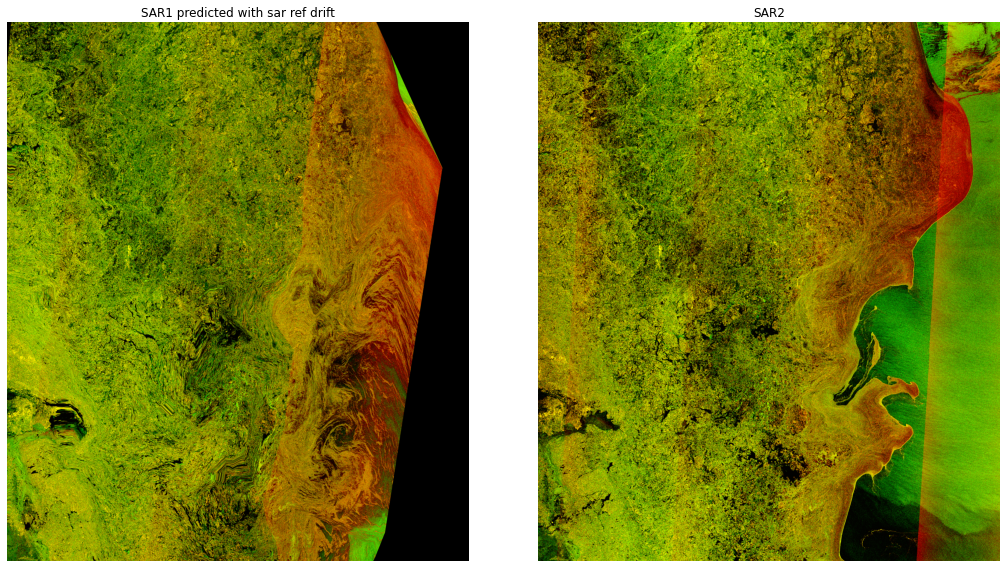

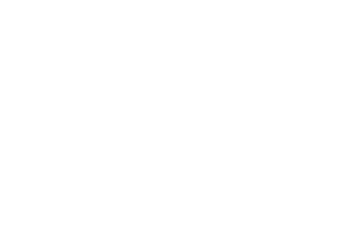

In [18]:
# Display the composite image
fig, axs = plt.subplots(1,2, figsize=(15,8))

# Display images
axs[0].imshow(rgb_image1)
axs[1].imshow(rgb_image2)


# Set titles
axs[0].set_title('SAR1 predicted with sar ref drift')
axs[1].set_title('SAR2')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([0, 3000])
    ax.set_ylim([5500, 2000])
    ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

plt.axis('off')
plt.show()

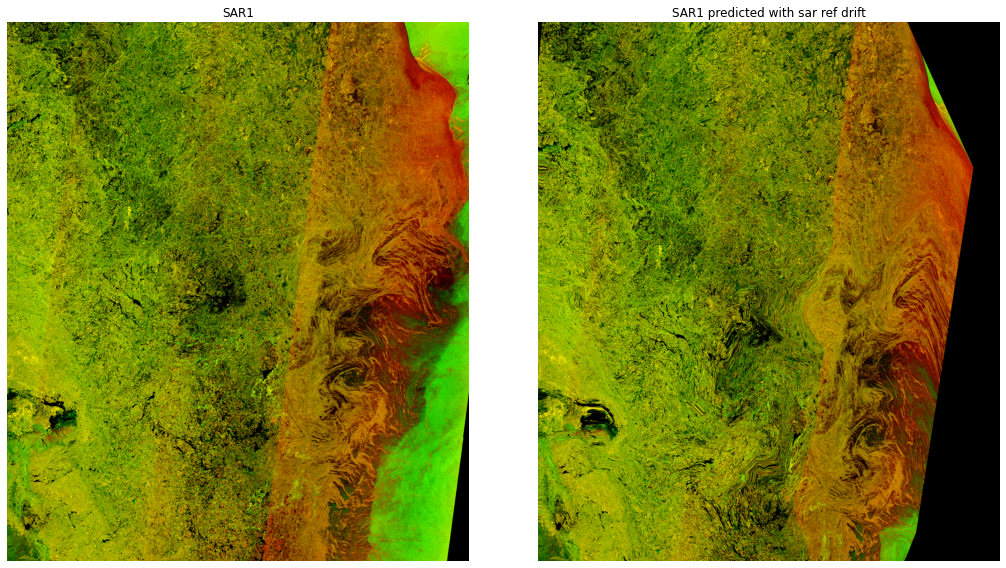

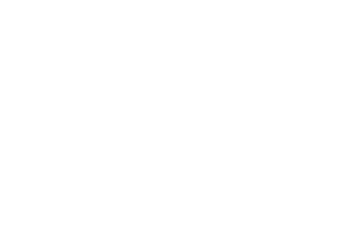

In [21]:
# Display the composite image
fig, axs = plt.subplots(1,2, figsize=(15,8))

# Display images
axs[0].imshow(rgb_image3)
axs[1].imshow(rgb_image1)


# Set titles
axs[0].set_title('SAR1')
axs[1].set_title('SAR1 predicted with sar ref drift')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([0, 3000])
    ax.set_ylim([5500, 2000])
    ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

plt.axis('off')
plt.show()

In [ ]:
# Display the composite image
fig, axs = plt.subplots(1,3, figsize=(20,8))

# Display images
axs[0].imshow(rgb_image3)
axs[1].imshow(rgb_image1)
axs[2].imshow(rgb_image2)


# Set titles
axs[0].set_title('SAR1')
axs[1].set_title('SAR1 predicted with sar ref drift')
axs[2].set_title('SAR2')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([500, 2100])
    ax.set_ylim([4800, 2800])
    #ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

plt.axis('off')
plt.show()

In [ ]:
def normalize(array):
    """Normalize an array to the range [0, 1]."""
    array_min = array.min()
    array_max = array.max()
    return (array - array_min) / (array_max - array_min)

def gamma_correction(image, gamma):
    """Apply gamma correction to an image."""
    return image ** (1.0 / gamma)

# Set your desired gamma value
gamma_value = 1.2


# Normalize the HV and HH bands
s2_hv_norm = normalize(s2_dst_dom_hv)
s2_hh_norm = normalize(s2_dst_dom_hh)

s1_predicted_hv_norm = normalize(s1_dst_dom_S_hv)
s1_predicted_hh_norm = normalize(s1_dst_dom_S_hh)

# Apply gamma correction
s2_hv_gamma_corrected = gamma_correction(s2_hv_norm, gamma_value)
s2_hh_gamma_corrected = gamma_correction(s2_hh_norm, gamma_value)

s1_predicted_hv_gamma_corrected = gamma_correction(s1_predicted_hv_norm, gamma_value)
s1_predicted_hh_gamma_corrected = gamma_correction(s1_predicted_hh_norm, gamma_value)

# Create an empty green channel
blue_channel = np.zeros_like(hv_gamma_corrected)

# Stack the channels to make a composite RGB image
rgb_image1 = np.stack([hv_gamma_corrected, hh_gamma_corrected, blue_channel], axis=-1)
rgb_image2 = np.stack([hv_gamma_corrected, hh_gamma_corrected, blue_channel], axis=-1)

# Display the composite image
fig, axs = plt.subplots(1,2, figsize=(15,8))

# Display images
axs[0].imshow(rgb_image1)
axs[1].imshow(rgb_image2)


# Set titles
axs[0].set_title('SAR1 predicted with sar ref drift')
axs[1].set_title('SAR2')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([0, 3000])
    ax.set_ylim([5500, 2000])
    ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

plt.axis('off')
plt.show()


NameError: name 'rgb_image1' is not defined

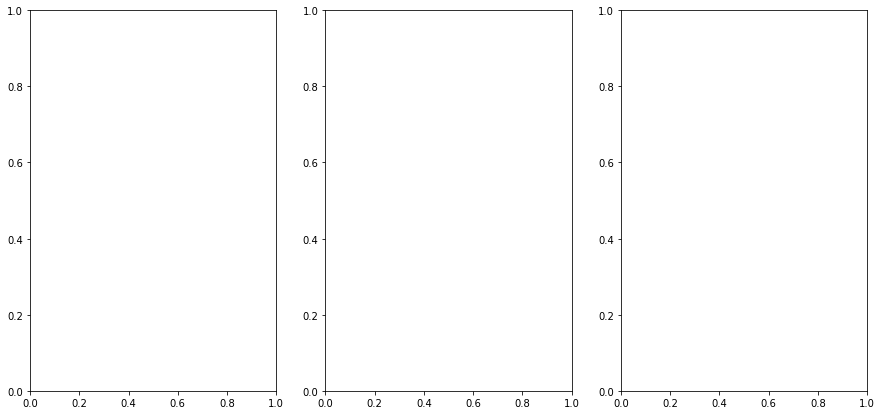

In [45]:
fig, axs = plt.subplots(1,3, figsize=(15,7))


# Display images
axs[0].imshow(rgb_image1)
axs[1].imshow(rgb_image2)


# Set titles
axs[0].set_title('SAR1 predicted with sar ref drift')
axs[1].set_title('SAR2')


# Set common xlim and ylim for all subplots
for ax in axs:
    ax.set_xlim([0, 3000])
    ax.set_ylim([5500, 2000])
    ax.axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()
